In [20]:
"""
Created on Aug 8 14:24:37 2020

@author: Nicolas Matentzoglu
"""

import os, sys
import yaml
import urllib.request
from shutil import copyfile
import pandas as pd
from subprocess import check_call
from lib import uPhenoConfig, get_defined_phenotypes

### Configuration
yaml.warnings({'YAMLLoadWarning': False})
#upheno_config_file = sys.argv[1]
upheno_config_file = os.path.join("/Users/matentzn/ws/upheno-dev/src/curation/upheno-config.yaml")
ws = "/Users/matentzn/ws/upheno-dev/src"


In [21]:

upheno_config = uPhenoConfig(upheno_config_file)
os.environ['ROBOT_JAVA_ARGS'] = upheno_config.get_robot_java_args()

TIMEOUT=str(upheno_config.get_external_timeout())
robot_opts=upheno_config.get_robot_opts()

pattern_dir = os.path.join(ws,"curation/patterns-for-matching/")
stats_dir = os.path.join(ws,"curation/upheno-stats2/")
matches_dir = os.path.join(ws,"curation/pattern-matches/")



In [22]:
def get_all_phenotypes(upheno_config,stats_dir):
    phenotypes = []
    for oid in upheno_config.get_phenotype_ontologies():
        phenotype_class_metadata = os.path.join(stats_dir,oid+"_phenotype_data.csv")
        if os.path.exists(phenotype_class_metadata):
            try:
                df = pd.read_csv(phenotype_class_metadata)
                df['o']=oid
                phenotypes.append(df)
            except:
                print("{} could not be loaded..".format(phenotype_class_metadata))
        else:
            print("{} does not exist!".format(phenotype_class_metadata))
    return pd.concat(phenotypes)


In [25]:
defined = get_defined_phenotypes(upheno_config,pattern_dir,matches_dir)
df_pheno = get_all_phenotypes(upheno_config,stats_dir)
df_pheno['upheno']=df_pheno['s'].isin(defined)
df_pheno['eq']=df_pheno['ldef'].notna()
df_pheno.drop_duplicates(inplace=True)

print("Summary: ")
print(df_pheno.head())
print(df_pheno.describe())
print("")
print("How many uPheno conformant classes?")
print(df_pheno[['s','upheno']].groupby('upheno').count())
print("")
print("How many classes with EQs?")
print(df_pheno[['s','eq']].groupby('eq').count())
print("")
print("How many uPheno conformant classes that do not have EQs (bug!!)?")
print(df_pheno[df_pheno['upheno'] & (~df_pheno['eq'])])
print(df_pheno[df_pheno['upheno']][['s','eq']].groupby('eq').count())
df_pheno.to_csv(os.path.join(stats_dir,"pheno_eq_analysis.csv"))

Summary: 
                                           s                              lab  \
0  http://purl.obolibrary.org/obo/MP_0000001              mammalian phenotype   
1  http://purl.obolibrary.org/obo/MP_0001186           pigmentation phenotype   
2  http://purl.obolibrary.org/obo/MP_0002075  abnormal coat/hair pigmentation   
3  http://purl.obolibrary.org/obo/MP_0000372      irregular coat pigmentation   
4  http://purl.obolibrary.org/obo/MP_0005366            variegated coat color   

   ldef   o  upheno     eq  
0   NaN  mp   False  False  
1  _:b0  mp   False   True  
2  _:b1  mp   False   True  
3  _:b2  mp   False   True  
4  _:b3  mp   False   True  
                                                s  \
count                                       61498   
unique                                      61498   
top     http://purl.obolibrary.org/obo/MP_0008321   
freq                                            1   

                                  lab    ldef      o upheno    

In [80]:
#del df_pheno['ldef']
#del df_pheno['lab']
df_pheno.head()


,s,o,upheno,eq
0,http://purl.obolibrary.org/obo/MP_0000001,mp,False,False
1,http://purl.obolibrary.org/obo/MP_0001186,mp,False,True
2,http://purl.obolibrary.org/obo/MP_0002075,mp,False,True
3,http://purl.obolibrary.org/obo/MP_0000372,mp,False,True
4,http://purl.obolibrary.org/obo/MP_0005366,mp,False,True


In [81]:
df_pheno_o=df_pheno[['s','o']].groupby(['o']).count()
df_pheno_o=df_pheno_o.add_suffix('_Count').reset_index()
df_pheno_o.columns=['o','total_phenotypes']
df_pheno_o

,o,total_phenotypes
0,hp,14374
1,mp,12936
2,wbphenotype,2546
3,zp,31642


In [82]:
df_pheno_o_eq=df_pheno[['s','o','eq']].groupby(['o','eq']).count()
df_pheno_o_eq=df_pheno_o_eq.add_suffix('_Count').reset_index()
df_pheno_o_eq=df_pheno_o_eq[df_pheno_o_eq['eq']]
del df_pheno_o_eq['eq']
df_pheno_o_eq.columns=['o','total_eq']
df_pheno_o_eq

,o,total_eq
1,hp,5866
3,mp,9622
5,wbphenotype,953
6,zp,31642


In [85]:
df_pheno_o_eq_upheno=df_pheno[['s','o','upheno']].groupby(['o','upheno']).count()
df_pheno_o_eq_upheno=df_pheno_o_eq_upheno.add_suffix('_Count').reset_index()
df_pheno_o_eq_upheno=df_pheno_o_eq_upheno[df_pheno_o_eq_upheno['upheno']]
del df_pheno_o_eq_upheno['upheno']
df_pheno_o_eq_upheno.columns=['o','upheno']
df_pheno_o_eq_upheno

,o,upheno
1,hp,3189
3,mp,6038
5,wbphenotype,631
7,zp,17170


In [97]:
result = pd.merge(df_pheno_o, df_pheno_o_eq, on='o')
result = pd.merge(result, df_pheno_o_eq_upheno, on='o')
result['remain_no_def']=result['total_phenotypes']-result['total_eq']
result['eq_not_upheno']=result['total_eq']-result['upheno']
result=result[['o','remain_no_def','eq_not_upheno','upheno','total_phenotypes']]
result['pc_remain_no_def']=(result['remain_no_def']/result['total_phenotypes'])
result['pc_eq_not_upheno']=(result['eq_not_upheno']/result['total_phenotypes'])
result['pc_upheno']=(result['upheno']/result['total_phenotypes'])
r=result[['o','pc_remain_no_def','pc_eq_not_upheno','pc_upheno']]


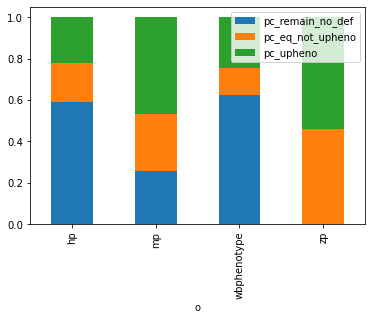

In [100]:
r.set_index('o').plot(kind='bar', stacked=True)